In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from patsy import dmatrix

import causalpy as cp

## Setting for Mac OS spawning multi-process defaults on M1 chip
sampler_kwargs = {"tune": 2000, "draws": 2000, "target_accept": 0.95, "mp_ctx": "spawn"}

## The Pardox of Propensity Scores in Bayesian Inference

In causal inference the role of the propensity score is often seen to be central. We've seen how the propensity score can be used with the `cp.InversePropensityWeighting` class to correct for a species of selection bias by re-weighting our outcome variable and calculating a causal contrast on the re-weighted scale. Additionally we can use the propensity score to visualise and diagnose problems of overlap or covariate balancing across treatment and control groups. 

These properties give the propensity score a large role to play in _design based_ approaches to causal inference. The focus is on assessing aspects of the treatment allocation to ensure we have identifiability assurances for estimands of interest. 

When we use `cp.InversePropensityWeighting` to apply various re-weighting techniques we perform a two-step  manoeuvre: (1) we estimate the propensity score and (2) apply the inverse-weighting of the score to transform our outcome variable and assess causal contrasts. But being good Bayesians, we might wonder why go to all this trouble? Can we not simple estimate a full-bayesian model of treatment and outcome simultaneously?

In this notebook we'll show why we should be careful attempting to model the joint-distribution of the propensity score and the outcome variable, but still make good use of the propensity score. 

### Brief Digression on the Mathematics

Consider that we have the following three variables:

$$ P(Y, T, X) $$ 

where $Y$ is our outcome variable, $T$ is our treatment variable, and $X$ stands in for all other control variables in scope. Now define the propensity score

$$ e(X) = P(T | X)$$

and our outcome model

$$ P(Y | T, X) = \dfrac{P(Y, T, X)}{P(T, X)}\cdot P(T, X) = \dfrac{P(Y | T, X) \cdot P(T | X) \cdot P(X)}{P(T | X) \cdot P(X)} P(T, X) = \dfrac{P(Y | T, X) \cdot e(X)\cdot P(X)}{e(X) \cdot P(X)} \cdot P(T, X) $$

but now it's clearer to see how the propensity score just cancels out. When we're already conditioning on $X, T$ the information in the propensity score is technically redundant in the Bayesian setting. Add the assumption of unconfoundedness or ignorability used in causal inference. We are arguing that there is no umeasured confounding so conditioning on $X, T$ should be sufficient to identify the causal contrast of interest. 

### Structure of the Presentation

We will first consider a simple simulated data set where we know the true values of the data generating process. We'll first demonstrate how to fit the joint distribution of the propensity score and the outcome in a single joint distribution using `PyMC`. Then we'll show how to fit a two-stage version of the same model. In both models we assume independent priors between the regression for the treatment and the regression for the outcome variable. Nevertheless, we will show that the joint model exhibits a bias due to feedback when there is non-measured confounding i.e. when there is misspecified outcome model. 

- Model Specification
    - Joint Model
    - 2 Stage Model
- Application to Simulated Outcome
- Application to Mosquito Net Data
- Application to Lalonde Data
- Application to NHEFS data.

Note the presentation here owes a debt to the work of Fan Li in {cite:p}`liBayesianProp` and her presentation [here](https://youtu.be/_BjkF2nl7dg?si=Pmza3EoTpz-flT8m&t=26). Additionally we drew on the work and data of Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/18/bayesian-propensity-scores-weights/) and Jordan Nafa and Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/20/fully-bayesian-ate-iptw/). 

#### Generate Some Data

In [2]:
N = 4000


def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


df1 = pd.DataFrame(
    {
        "x1": np.random.normal(0, 1, N),
        "x2": np.random.normal(0, 1, N),
        "x3": np.random.normal(0, 1, N),
    }
)

TREATMENT_EFFECT = 2
df1["trt"] = np.random.binomial(1, inv_logit(df1["x1"] + 6 * df1["x2"] + 7 * df1["x3"]))
df1["outcome"] = (
    1
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + 0.2 * df1["x2"]
    + -3 * df1["x3"]
    + np.random.normal(0, 1, N)
)


df1.head()

,x1,x2,x3,trt,outcome
0,0.523488,0.044881,0.671594,1,1.995582
1,-0.601303,1.339160,0.723706,1,0.008482
2,-0.073837,-0.425303,0.582251,0,-1.986655
3,-0.481951,-0.515395,-0.383367,0,1.637298
4,1.600781,0.092157,0.348892,1,2.545765


### Specifying the Joint Model

Here we will define a model context that fits our data simultaneously for treatment and outcome. We allow that the propensity score estimated in the treatment model is used in a non-parametric spline to flexibly inform the outcome variable

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


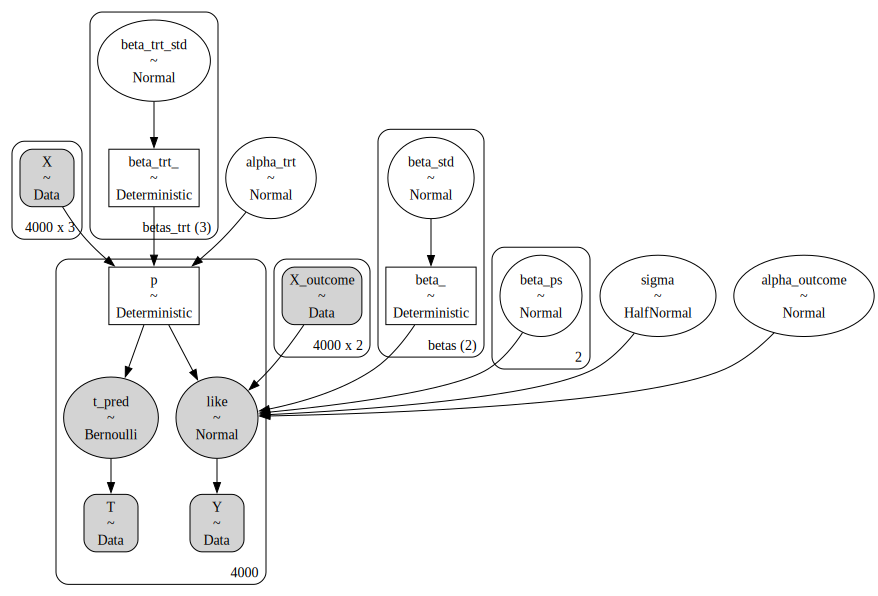

In [3]:
coords = {
    "betas": ["trt", "x1"],
    "betas_trt": ["x1", "x2", "x3"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2", "x3"]].values
X_outcome = df1[["trt", "x1"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
        "sigma": 1,
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data, mutable=True)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps = pm.Normal("beta_ps", 0, 1, size=2)

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + beta_ps[0] * p
            + beta_ps[1] * (p * T_data)
        )
        sigma = pm.HalfNormal("sigma", priors["sigma"])

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

Note how the two likelihood terms are fit simultaneously. 

### Specifying the 2 Stage Model

Here we allow for a function that takes the same inputs but fits two separate models. First we fit the treatment model then store the `idata_treatment` this xarray object stores the posterior estimates for the propensity score. We pass this through to a second outcome model where we proceed to take a random draw from the posterior and pass it through to the outcome regression via a spline component. This allows us to express any non-linearity in the treatment effect. Additionally it can be seen as a way to augment the outcome model.

While theoretically the propensity score contains no extra information if we are already conditioning on $X$, practically the literature reports that the propensity improves the stability of the causal estimates achievable in Bayesian causal modelling. 

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


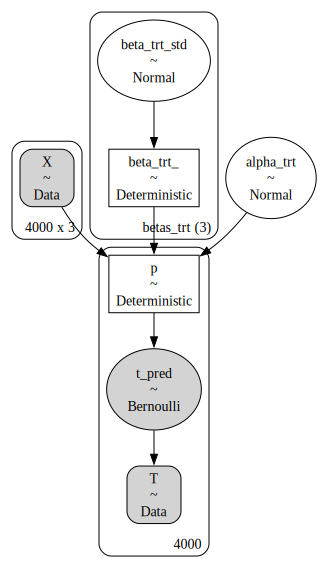

In [4]:
def make_treatment_model(
    X_trt,
    T_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model_trt:
        X_data_trt = pm.Data("X", X_trt)
        T_data_ = pm.Data("T", T_data, mutable=True)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)
    return model_trt


def make_outcome_model(
    X_outcome,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
        "sigma": 1,
    },
    noncentred=True,
    spline_component=False,
    propensity_score_idata=None,
):
    propensity_scores = az.extract(propensity_score_idata)["p"]
    with pm.Model(coords=coords) as model_outcome:
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps = pm.Normal("beta_ps", 0, 1, size=2)

        chosen = np.random.choice(range(propensity_scores.shape[1]))
        p = propensity_scores[:, chosen].values

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + beta_ps[0] * p
            + beta_ps[1] * (p * T_data)
        )

        if spline_component:
            beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)
            B = dmatrix(
                "bs(ps, knots=knots, degree=3, include_intercept=True, lower_bound=0, upper_bound=1) - 1",
                {"ps": p, "knots": np.linspace(0, 1, 30)},
            )
            B_f = np.asarray(B, order="F")
            splines_summed = pm.Deterministic(
                "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
            )
            mu_outcome = mu_outcome + splines_summed

        sigma = pm.HalfNormal("sigma", priors["sigma"])

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model_outcome


def make_2step_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, spline_component=False
):
    treatment_model = make_treatment_model(X_trt, T_data, coords, priors)
    with treatment_model:
        idata_treatment = pm.sample_prior_predictive()
        idata_treatment.extend(pm.sample(**sampler_kwargs))

    outcome_model = make_outcome_model(
        X_outcome,
        Y_data,
        coords,
        priors,
        spline_component,
        propensity_score_idata=idata_treatment,
    )
    with outcome_model:
        idata_outcome = pm.sample_prior_predictive()
        idata_outcome.extend(pm.sample(**sampler_kwargs))

    return idata_treatment, idata_outcome, treatment_model, outcome_model


model_treatment = make_treatment_model(X_trt, T_data, coords)

pm.model_to_graphviz(model_treatment)

### Putting it all Together

In [5]:
priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [0, 1],
    "sigma": 1,
}

joint_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with joint_model:
    idata_joint = pm.sample(**sampler_kwargs)

(
    idata_treatment_2s_joint,
    idata_outcome_2s_joint,
    treatment_model_joint,
    outcome_model_joint,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
Sampling: [alpha_outcome, beta_, beta_ps, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_, beta_ps, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


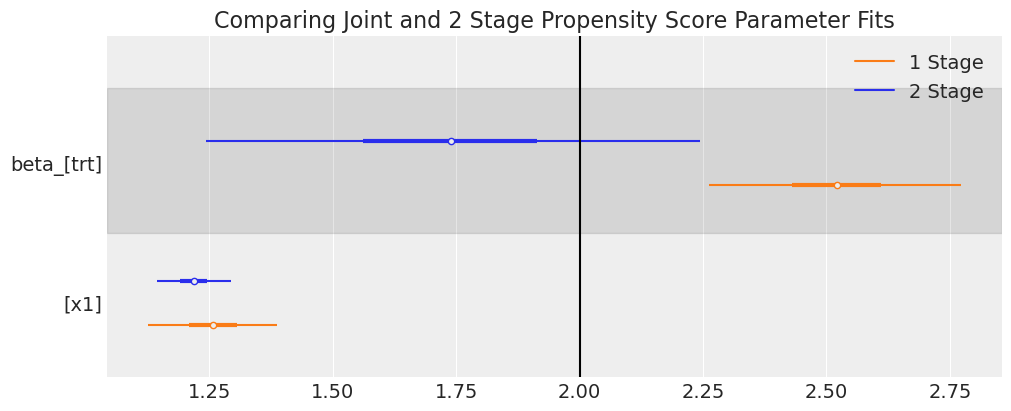

In [6]:
ax = az.plot_forest(
    [idata_outcome_2s_joint, idata_joint],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(2, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [7]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_joint, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_joint, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt      -0.021  0.025  -0.068    0.025      0.000   
              beta_[trt]      2.521  0.135   2.263    2.772      0.002   
              beta_[x1]       1.257  0.071   1.125    1.388      0.001   
              beta_ps[0]    -15.290  0.311 -15.905  -14.732      0.005   
              beta_ps[1]     -0.428  0.243  -0.883    0.037      0.004   
              alpha_outcome   8.468  0.158   8.181    8.773      0.003   
2-stage-model beta_[trt]      1.739  0.264   1.244    2.244      0.004   
              beta_[x1]       1.218  0.040   1.143    1.294      0.000   
              alpha_outcome   3.206  0.061   3.097    3.327      0.001   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt        0.000    5020.0    5717.0    1.0  
              beta_[trt]       0.002    4231.0    4610.0    1.0  
              beta_[x1]        0.001    4655.0    4823.0    1.0  
              beta_ps[0]       0.004    3236.0    3978.0    1.0  
              beta_ps[1]       0.003    4225.0    4430.0    1.0  
              alpha_outcome    0.002    3416.0    4224.0    1.0  
2-stage-model beta_[trt]       0.003    5099.0    5160.0    1.0  
              beta_[x1]        0.000    7245.0    5765.0    1.0  
              alpha_outcome    0.001    6023.0    5902.0    1.0

Here the models fail to recover substantially similar and correct results. This is interesting and demonstrates a key property of propensity scores in the Bayesian setting. 

### The Problem of Feedback

The issue here is sometimes called Bayesian feedback or "collider bias via the likelihood", and it's a key issue when trying to build joint models for causal inference in the Bayesian paradigm. Because we have fit the outcome and the treatment models simultaneously, and this means that the outcome can influence the posterior distribution of the parameters $\beta$ in the treatment model and it violates the idea of design-before-analysis. We have here an apparent example of a slight bias due to this effect.  The two stage modular approach seems to better recover the treatment effect reported in the literature and avoids the risk of collider bias i.e. in the modular implementation we are able to use the propensity score to adjust for accuracy and compensate for the missing variables `x2` and `x1`. 

<div style="border-left: 4px solid #007acc; padding: 0.5em 1em; background-color: #f0f8ff;">

**💡 Key Take-away:** With an underspecified outcome model, we may use a well specified propensity score for adjusting the model to retrieve accurate treatment effect estimates. However, this tends to breakdown if we have estimated both propensity score and outcome in a joint bayesian model due to feedback effects. The solution is to use the propensity score in a 2 stage fashion. 

</div>

#### Propensity Score Quantiles - Joint Model

In [8]:
idata_joint["posterior"]["p"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
).round(3)

<xarray.DataArray 'p' (quantile: 9)> Size: 72B
array([0.218, 0.296, 0.363, 0.424, 0.489, 0.549, 0.615, 0.685, 0.763])
Coordinates:
  * quantile  (quantile) float64 72B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9

#### Propensity Score Quantiles - 2 Stage Modular Model

In [9]:
idata_treatment_2s_joint["posterior"]["p"].quantile(
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
).round(3)

<xarray.DataArray 'p' (quantile: 9)> Size: 72B
array([0.   , 0.001, 0.011, 0.077, 0.389, 0.837, 0.978, 0.998, 1.   ])
Coordinates:
  * quantile  (quantile) float64 72B 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9

### Causal Estimate with Do-Operator

We can also confirm the model implications through counterfactual imputation. This ties the Bayesian setting back the potential outcomes framework. The fundamental problem of causal inference, when seen as a missing data problem allows us to derive causal estimands through imputation of the potential outcomes. Here we "push forward" the posterior predictive distribution for $Y$ under different treatment settings. 

In [10]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0

In [11]:
with pm.do(
    joint_model,
    {"T": np.ones(len(df1), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

with pm.do(
    joint_model,
    {"T": np.zeros(len(df1), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [12]:
idata_trt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(3.38591982)

In [13]:
idata_ntrt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(0.86502058)

In [14]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(2.52089924)

## Nets Example

Next we'll asses a data set used by Andrew Heiss to demonstrate propensity score methods with `brms`. 

In [15]:
nets_df = pd.read_csv("../../../causalpy/data/nets_df.csv")
nets_df["trt"] = nets_df["net_num"]
nets_df["outcome"] = nets_df["malaria_risk"]
nets_df

,id,net,net_num,malaria_risk,income,health,household,eligible,temperature,resistance,trt,outcome
0,1,True,1,33,781,56,2,False,21.1,59,1,33
1,2,False,0,42,974,57,4,False,26.5,73,0,42
2,3,False,0,80,502,15,3,False,25.6,65,0,80
3,4,True,1,34,671,20,5,True,21.3,46,1,34
4,5,False,0,44,728,17,5,False,19.2,54,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1748,True,1,18,961,27,4,False,22.1,27,1,18
1748,1749,False,0,49,906,49,5,False,30.7,55,0,49
1749,1750,False,0,17,1325,92,2,False,21.4,52,0,17
1750,1751,False,0,46,879,33,6,False,27.4,62,0,46


In [16]:
coords = {
    "betas": ["trt", "income"],
    "betas_trt": ["income", "temperature", "health"],
    "obs": range(nets_df.shape[0]),
}

# Process and Standardise Inputs
N = nets_df.shape[0]
X_trt = nets_df[["income", "temperature", "health"]].values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = nets_df[["trt", "income"]].values
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = nets_df["trt"].values
X_outcome[:, 0] = T_data
Y_data = nets_df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [40, 30],
    "sigma": 10,
}
net_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with net_model:
    idata_net = pm.sample(tune=2000, target_accept=0.98)

idata_treatment_2s_net, idata_outcome_2s_net, treatment_model_net, outcome_model_net = (
    make_2step_model(
        X_trt, X_outcome, T_data, Y_data, coords, priors=priors, spline_component=True
    )
)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
Sampling: [alpha_outcome, beta_ps, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.


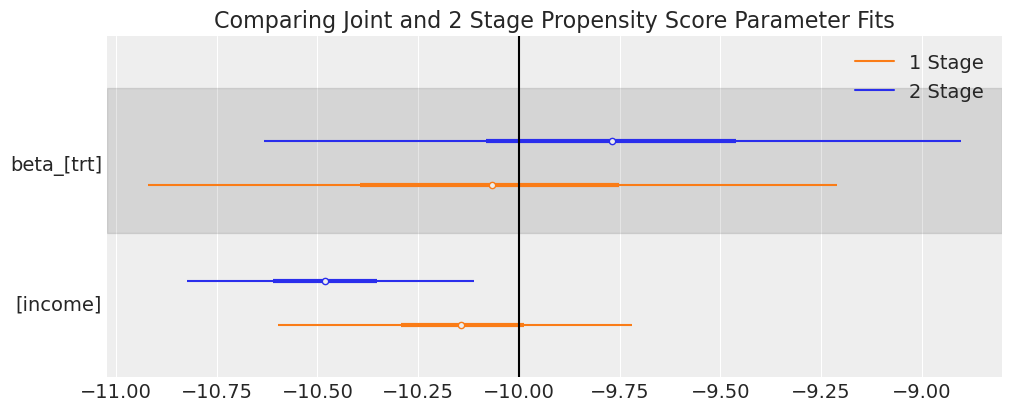

In [17]:
ax = az.plot_forest(
    [idata_outcome_2s_net, idata_net],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(-10, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [18]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_net, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_net, var_names=["beta_", "alpha_outcome", "beta_ps"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt      -0.259  0.052  -0.358   -0.164      0.001   
              beta_[trt]    -10.067  0.459 -10.922   -9.210      0.010   
              beta_[income] -10.140  0.230 -10.598   -9.720      0.005   
              beta_ps[0]    -16.334  0.706 -17.639  -15.010      0.015   
              beta_ps[1]      0.227  0.858  -1.445    1.758      0.020   
              alpha_outcome  46.746  0.418  45.953   47.488      0.010   
2-stage-model beta_[trt]     -9.769  0.456 -10.632   -8.902      0.006   
              beta_[income] -10.481  0.191 -10.824  -10.110      0.003   
              alpha_outcome  42.649  0.416  41.863   43.427      0.007   
              beta_ps[0]     -8.073  0.954  -9.883   -6.319      0.016   
              beta_ps[1]     -0.913  0.872  -2.589    0.700      0.012   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt        0.001    2743.0    2641.0    1.0  
              beta_[trt]       0.006    1997.0    2631.0    1.0  
              beta_[income]    0.003    2052.0    2438.0    1.0  
              beta_ps[0]       0.010    2099.0    2470.0    1.0  
              beta_ps[1]       0.012    1856.0    2765.0    1.0  
              alpha_outcome    0.007    1742.0    2238.0    1.0  
2-stage-model beta_[trt]       0.004    5962.0    6149.0    1.0  
              beta_[income]    0.002    4637.0    5309.0    1.0  
              alpha_outcome    0.005    3657.0    4518.0    1.0  
              beta_ps[0]       0.011    3730.0    4650.0    1.0  
              beta_ps[1]       0.009    5708.0    6082.0    1.0

Here again we see broad consistency between both model specifications indicating that the regression adjustment approach in the 2 stage outcome model is appropriate and picks up on all relevant sources of confounding. This is despite the fact that we removed useful predictors `temperature`, `health` from the outcome model specification. The model leans on the information contained in the propensity score and weights the `beta_ps` information appropriately. 

## LaLonde Example

The Lalonde Data set is famous because it highlights a problem with naive causal contrasts. It is discussed by Angrist and Pischke in their _Mostly Harmless Econometrics_ as an example of how regression controls can tolerably address selection effects in a way similar to propensity score weighting. So we should hope the a well specified outcome model can identify the treatment effects plausibly here too. 

In [19]:
lalonde = pd.read_csv("../../../causalpy/data/lalonde.csv")
lalonde[["hispan", "white"]] = pd.get_dummies(lalonde["race"], drop_first=True)
lalonde.dropna(inplace=True)
lalonde.head()

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78,hispan,white
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460,False,False
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940,True,False
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500,False,False
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460,False,False
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899,False,False


In [20]:
lalonde.groupby("treat")["re78"].mean().diff()

treat
0           NaN
1   -635.026212
Name: re78, dtype: float64

The Naive group difference suggests a negative effect. Lets see how our two models work when we remove predictors from the propensity model?

In [21]:
coords = {
    "betas": ["treat", "age", "educ", "hispan", "white", "married", "nodegree"],
    "betas_trt": ["hispan", "white", "married", "nodegree"],
    "obs": range(lalonde.shape[0]),
}

N = lalonde.shape[0]
X_trt = lalonde[["hispan", "white", "married", "nodegree"]].astype(np.int32).values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)

X_outcome = (
    lalonde[["treat", "age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
# X_outcome = (X_outcome - X_outcome.mean()) / X_outcome.std()
T_data = lalonde["treat"].values
Y_data = lalonde["re78"].values


priors = {
    "beta_": [0, 4000],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [2000, 500],
    "sigma": 500,
}

lalonde_model = make_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, noncentred=False
)

with lalonde_model:
    idata_lalonde = pm.sample(tune=5000)

(
    idata_treatment_2s_lalonde,
    idata_outcome_2s_lalonde,
    treatment_model_lalonde,
    outcome_model_lalonde,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_, beta_, beta_ps, alpha_trt, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 10 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
Sampling: [alpha_outcome, beta_, beta_ps, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_, beta_ps, alpha_outcome, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.


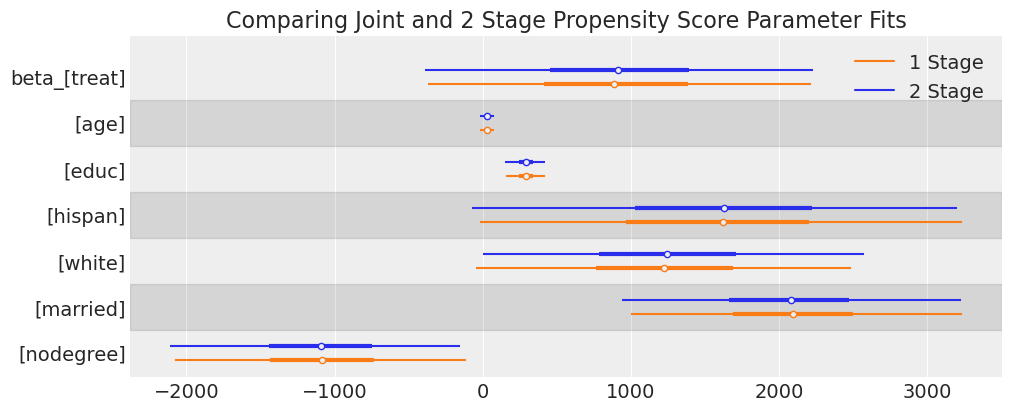

In [22]:
ax = az.plot_forest(
    [idata_outcome_2s_lalonde, idata_lalonde],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [23]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_lalonde,
            var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome", "sigma"],
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_lalonde,
            var_names=["beta_", "beta_ps", "alpha_outcome", "sigma"],
        ),
    }
)
compare_estimate

mean       sd    hdi_3%   hdi_97%  \
1-stage-model alpha_trt          -1.337    0.135    -1.597    -1.092   
              beta_[treat]      897.593  698.918  -367.100  2217.513   
              beta_[age]         29.940   25.449   -18.837    77.058   
              beta_[educ]       292.139   69.657   158.567   421.276   
              beta_[hispan]    1593.906  883.750   -19.172  3233.629   
              beta_[white]     1223.780  682.822   -47.044  2487.428   
              beta_[married]   2094.674  593.793   997.970  3234.417   
              beta_[nodegree] -1087.557  524.166 -2078.290  -110.903   
              beta_ps[0]         -0.008    0.997    -1.825     2.053   
              beta_ps[1]         -0.011    0.996    -1.986     1.771   
              alpha_outcome    1793.234  479.095   930.011  2728.542   
              sigma            6436.494  148.542  6161.420  6709.245   
2-stage-model beta_[treat]      921.166  695.150  -390.455  2227.062   
              beta_[age]         30.376   25.719   -17.570    77.473   
              beta_[educ]       290.383   70.739   152.531   420.041   
              beta_[hispan]    1624.045  880.940   -69.748  3202.882   
              beta_[white]     1246.571  682.593     3.316  2569.644   
              beta_[married]   2070.076  606.118   939.815  3228.152   
              beta_[nodegree] -1098.141  520.188 -2110.320  -152.275   
              beta_ps[0]         -0.010    1.003    -1.806     1.917   
              beta_ps[1]          0.014    0.980    -1.907     1.781   
              alpha_outcome    1798.640  482.733   875.017  2674.645   
              sigma            6435.687  149.728  6160.962  6721.915   

                               mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt            0.002    0.002    4572.0    2776.0    1.0  
              beta_[treat]        10.850    9.275    4157.0    3037.0    1.0  
              beta_[age]           0.334    0.421    5822.0    3104.0    1.0  
              beta_[educ]          1.035    1.075    4533.0    3515.0    1.0  
              beta_[hispan]       12.677   12.547    4869.0    3095.0    1.0  
              beta_[white]        10.840   10.030    3973.0    3295.0    1.0  
              beta_[married]       7.317    9.170    6555.0    3248.0    1.0  
              beta_[nodegree]      6.655    9.080    6221.0    2867.0    1.0  
              beta_ps[0]           0.012    0.020    7005.0    2347.0    1.0  
              beta_ps[1]           0.012    0.020    7336.0    2766.0    1.0  
              alpha_outcome        6.376    7.498    5616.0    2994.0    1.0  
              sigma                1.784    2.569    7060.0    3091.0    1.0  
2-stage-model beta_[treat]         9.542    7.521    5309.0    5872.0    1.0  
              beta_[age]           0.332    0.286    6032.0    5517.0    1.0  
              beta_[educ]          0.993    0.848    5076.0    5362.0    1.0  
              beta_[hispan]       11.429    9.389    5938.0    5211.0    1.0  
              beta_[white]         9.461    7.418    5213.0    5582.0    1.0  
              beta_[married]       6.936    6.706    7661.0    5838.0    1.0  
              beta_[nodegree]      6.249    5.268    6941.0    5636.0    1.0  
              beta_ps[0]           0.011    0.011    7743.0    6006.0    1.0  
              beta_ps[1]           0.010    0.011    9430.0    6466.0    1.0  
              alpha_outcome        5.671    5.460    7248.0    5663.0    1.0  
              sigma                1.706    1.675    7693.0    5575.0    1.0

Both estimates of the treatment effects accord well with values in the literature. We can be happy that both models are picking up on the treatment effects reasonably despite having a minimalist propensity score model. This is because in the Bayesian setting the conditional distribution of $X, T$ are generally sufficient when there is no unmeasured confounders. Here the model just ignores the propensity score coefficients `beta_ps`

## NHEFS 

Finally we turn to the NHEFS data. This data is known to be have a complex covariate profile for measuring aspects smokers health. We might suspect that there is some unmeasured confounding in this data set that would be hard to pick up on with simple regression controls. 

In [24]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [25]:
coords = {
    "betas": ["trt", "age", "smokeintensity", "smokeyrs", "wt71"],
    "betas_trt": [
        "age",
        "race",
        "sex",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
        "age^2",
        "wt71^2",
        "smokeintensity^2",
        "smokeyrs^2",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[
    [
        "age",
        "race",
        "sex",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
        "age^2",
        "wt71^2",
        "smokeintensity^2",
        "smokeyrs^2",
    ]
]
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = df[["trt", "age", "smokeintensity", "smokeyrs", "wt71"]]
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [10, 5],
    "sigma": 7,
}

nhefs_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors)
with nhefs_model:
    idata_nhefs = pm.sample(**sampler_kwargs)


(
    idata_treatment_2s_nhefs,
    idata_outcome_2s_nhefs,
    treatment_model_nhefs,
    outcome_model_nhefs,
) = make_2step_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors=priors, spline_component=True
)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
Sampling: [alpha_outcome, beta_ps, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps, alpha_outcome, sigma]


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


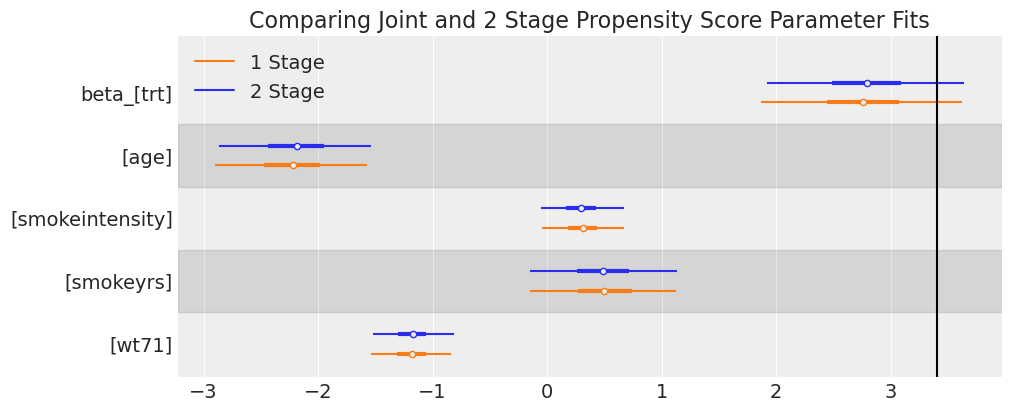

In [26]:
ax = az.plot_forest(
    [idata_outcome_2s_nhefs, idata_nhefs],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(3.4, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

Here we see the model specifications start to come apart. 

In [27]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_nhefs, var_names=["alpha_trt", "beta_", "alpha_outcome", "beta_ps"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_nhefs, var_names=["beta_", "alpha_outcome", "beta_ps"]
        ),
    }
)
compare_estimate[["mean", "sd", "hdi_3%", "hdi_97%", "r_hat"]]

mean     sd  hdi_3%  hdi_97%  r_hat
1-stage-model alpha_trt             -1.153  0.061  -1.260   -1.030    1.0
              beta_[trt]             2.754  0.468   1.869    3.623    1.0
              beta_[age]            -2.227  0.353  -2.900   -1.576    1.0
              beta_[smokeintensity]  0.308  0.190  -0.042    0.669    1.0
              beta_[smokeyrs]        0.502  0.345  -0.155    1.129    1.0
              beta_[wt71]           -1.185  0.188  -1.543   -0.840    1.0
              alpha_outcome          2.089  0.328   1.469    2.680    1.0
              beta_ps[0]            -0.644  0.988  -2.572    1.119    1.0
              beta_ps[1]             0.250  0.944  -1.502    2.011    1.0
2-stage-model beta_[trt]             2.790  0.461   1.915    3.641    1.0
              beta_[age]            -2.192  0.352  -2.868   -1.537    1.0
              beta_[smokeintensity]  0.297  0.192  -0.052    0.666    1.0
              beta_[smokeyrs]        0.489  0.342  -0.149    1.136    1.0
              beta_[wt71]           -1.177  0.186  -1.522   -0.818    1.0
              alpha_outcome          2.145  0.301   1.559    2.681    1.0
              beta_ps[0]            -0.912  0.879  -2.510    0.734    1.0
              beta_ps[1]             0.164  0.919  -1.477    1.900    1.0

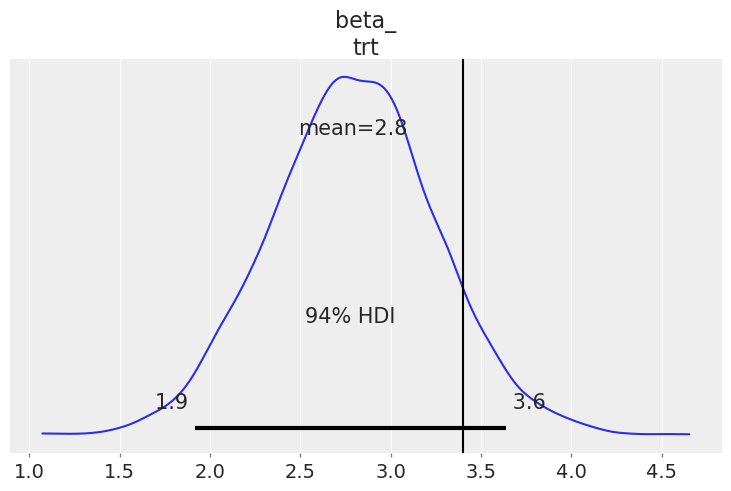

In [28]:
ax = az.plot_posterior(
    idata_outcome_2s_nhefs, var_names=["beta_"], coords={"betas": ["trt"]}
)
ax.axvline(3.4, color="k")

## Two-Stage Outcome Modelling with CausalPy


In [29]:
formula = """trt ~ 1 + age + race + sex + smokeintensity + smokeyrs + wt71 + active_1 + active_2 + 
         education_2 + education_3 + education_4 + education_5 + exercise_1 + exercise_2"""

df_standardised = (df - df.mean(axis=0)) / df.std(axis=0)
df_standardised["trt"] = df["trt"]
df_standardised["outcome"] = df["outcome"]
result = cp.InversePropensityWeighting(
    df_standardised,
    formula=formula,
    outcome_variable="outcome",
    weighting_scheme="robust",  ## Will be used by plots after estimation if no other scheme is specified.
    model=cp.pymc_models.PropensityScore(
        sample_kwargs={
            "chains": 4,
            "tune": 2000,
            "draws": 2000,
            "target_accept": 0.95,
            "random_seed": 18,
            "progressbar": False,
            "mp_ctx": "spawn",
        },
    ),
)

result

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.
Sampling: [beta_std, t_pred]
Sampling: [t_pred]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


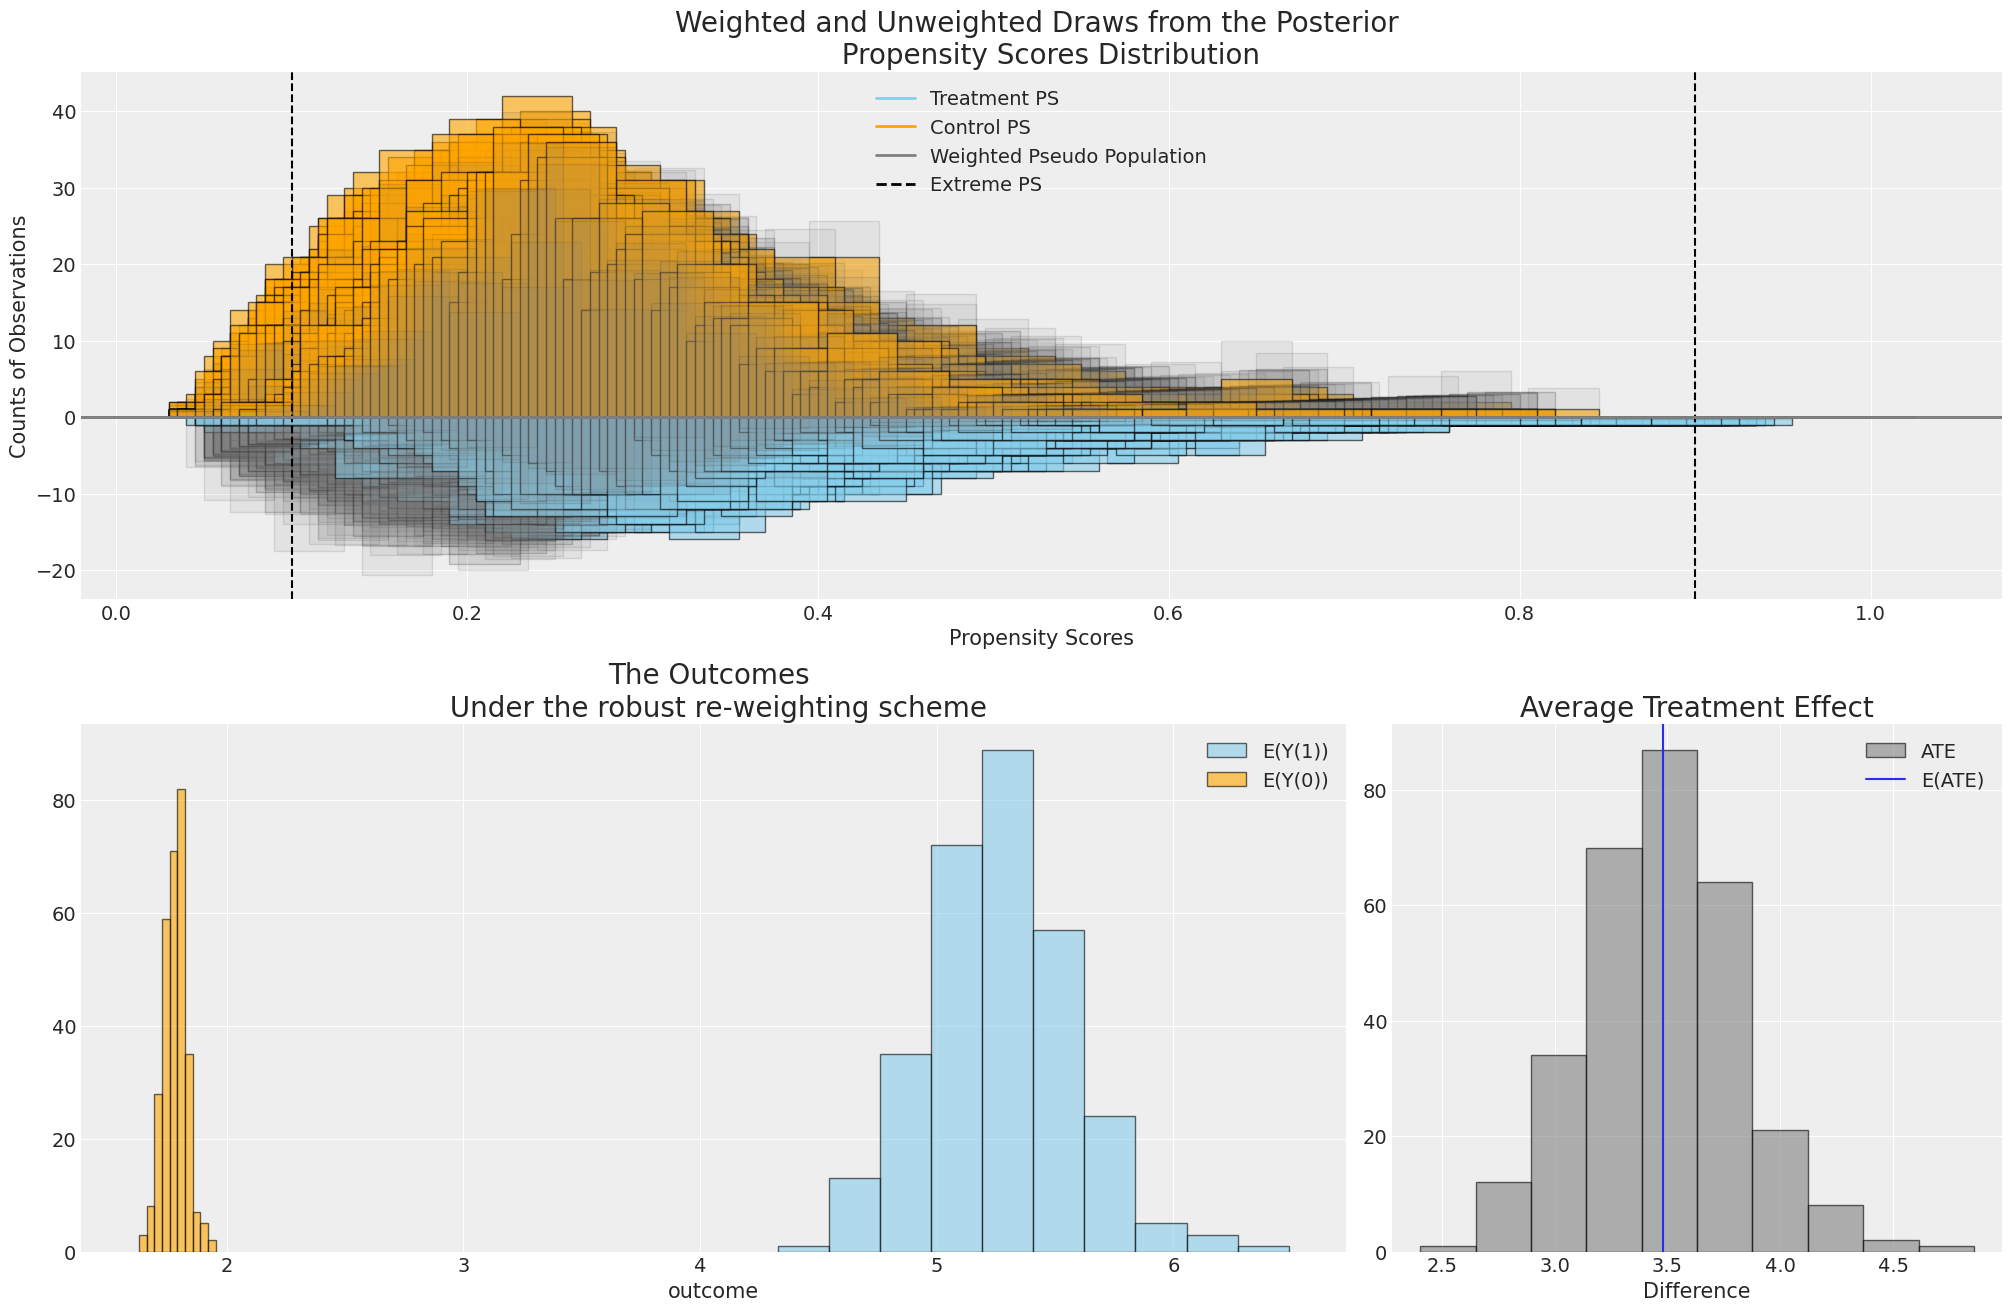

In [33]:
result.plot_ate(result.idata);

In [34]:
idata_outcome_cp, model_outcome_cp = result.model.fit_outcome_model(
    result.X_outcome,
    result.y,
    result.coords,
    priors={"b_outcome": [0, 1], "a_outcome": [0, 20], "sigma": 2},
    noncentred=True,
    normal_outcome=True,
)

Sampling: [a_outcome, beta_ps, beta_ps_spline, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, beta_ps, a_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


In [35]:
az.summary(idata_outcome_cp, var_names=["beta_"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_[Intercept],-0.003,1.015,-1.909,1.844,0.016,0.011,3946.0,4602.0,1.0
beta_[age],-1.975,0.375,-2.639,-1.235,0.006,0.004,4117.0,5160.0,1.0
beta_[race],0.154,0.198,-0.219,0.527,0.002,0.002,8149.0,6054.0,1.0
beta_[sex],-0.735,0.229,-1.161,-0.295,0.003,0.002,6210.0,5959.0,1.0
beta_[smokeintensity],0.210,0.206,-0.193,0.587,0.002,0.002,8713.0,6244.0,1.0
beta_[smokeyrs],0.256,0.362,-0.414,0.935,0.005,0.003,4542.0,5912.0,1.0
beta_[wt71],-1.451,0.202,-1.830,-1.074,0.002,0.002,7838.0,6009.0,1.0
beta_[active_1],-0.529,0.202,-0.903,-0.149,0.002,0.002,8360.0,5509.0,1.0
beta_[active_2],-0.107,0.196,-0.472,0.271,0.002,0.002,8146.0,5854.0,1.0
beta_[education_2],0.372,0.243,-0.067,0.826,0.003,0.002,5907.0,6390.0,1.0


## Conclusion: It' the Model Stupid!




## References
:::{bibliography}
:filter: docname in docnames
:::